# Exploring the claimant annotations

In [18]:
from enum import Enum
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from util import gather_dataset, gather_flattened_dataset, z_score_per_task, z_score_per_worker

In [2]:
class ClaimantType(Enum):
    named_individual = 1
    named_individual_with_role = 2
    role_or_profession_without_further_specifications = 3
    collective_expression = 4
    collective_role = 5
    inanimate_and_generic_object = 6

In [64]:
claimant_df = pd.read_csv('./annotations/claimant_annotations.csv')
claimant_df = claimant_df.drop('Unnamed: 0', axis=1)

# parse types into enum values
claimant_df['ClaimantType'] = claimant_df['ClaimantType'].apply(lambda type_: ClaimantType(int(type_.lstrip()[0]))) #type: ignore
# add readable format
claimant_df['claimant_type'] = claimant_df['ClaimantType'].apply(lambda type_: type_.name)

claimant_df.head()

,task_id,source,ClaimantType,claimant_type
0,f79dff90-7723-4c33-9582-33e46ab6176c,"Maimuna Majumder , a research fellow at Boston...",ClaimantType.named_individual_with_role,named_individual_with_role
1,f040bde3-4c11-482c-b7e3-4bd080b1a7f7,The article,ClaimantType.inanimate_and_generic_object,inanimate_and_generic_object
2,e3f62e34-fb40-4bda-a5b4-acd3d72c1160,Dr. Cherry,ClaimantType.named_individual_with_role,named_individual_with_role
3,edf664b7-4b4b-4eca-8bfb-dbb814528de7,My vet friend,ClaimantType.role_or_profession_without_furthe...,role_or_profession_without_further_specifications
4,cca66bf3-17a3-4c5d-8a91-ce303c7bc5a0,People in the middle ages,ClaimantType.collective_expression,collective_expression


ClaimantType
ClaimantType.inanimate_and_generic_object                         1072
ClaimantType.collective_role                                       468
ClaimantType.named_individual                                      399
ClaimantType.named_individual_with_role                            238
ClaimantType.role_or_profession_without_further_specifications     140
ClaimantType.collective_expression                                 133
Name: count, dtype: int64


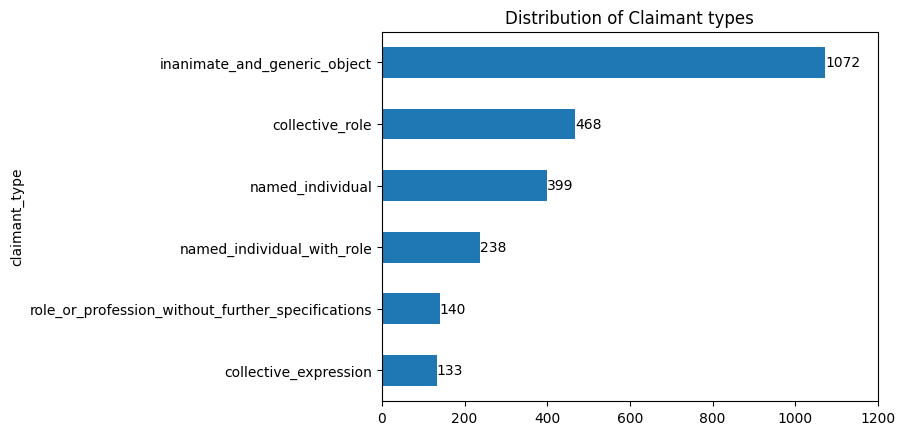

In [112]:
print(claimant_df['ClaimantType'].value_counts())

ax = claimant_df['claimant_type'].value_counts(ascending=True).plot(kind='barh', title='Distribution of Claimant types', xlim=(0,1200))
for container in ax.containers:
    ax.bar_label(container)

In [98]:
# load dataset
df = gather_dataset('./data/claimant_data_processed/')

# remove examples where the score is 0 (could not determine reliability)
df = df[df['score'] != 0]

df = pd.merge(df, claimant_df[['task_id', 'claimant_type']], on='task_id')

df = z_score_per_task(df)
df = z_score_per_worker(df)

# group df per claimant, and take the mean of each of their scores
grouped_df = df.groupby(['source', 'claimant_type'], as_index=False).agg(
    {'score': 'mean', 'z_score_worker': 'mean', 'z_score_task': 'mean'}
)

print(f'There are {len(grouped_df)} different types of claimants')
grouped_df.head()

/home/bbjoverbeek/master_thesis/util.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  z_scores_df = pd.concat(
/home/bbjoverbeek/master_thesis/util.py:48: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  z_scores_df = pd.concat(


There are 838 different types of claimants


,source,claimant_type,score,z_score_worker,z_score_task
0,' easytraveler ',inanimate_and_generic_object,3.134052,2.634428e-17,-0.140277
1,"( Keith Klugman , Emory University , personal ...",named_individual,3.489264,1.333866e-17,-0.046673
2,"( Michael Bruce , CDC , unpublished data )",inanimate_and_generic_object,3.954638,2.241547e-17,0.019836
3,"11 , no. 4 , August 1988 , pp. 304-9",inanimate_and_generic_object,2.785771,5.125456e-17,0.252658
4,13 % of polled professional scientists,collective_role,2.861575,2.672409e-17,-0.129485


### Statistics

In [100]:
import statsmodels.api as sm 
from statsmodels.formula.api import ols 
from typing import Literal

In [101]:
score_column: Literal['score', 'z_score_worker', 'z_score_task'] = 'score'

<Axes: title={'center': 'score'}, xlabel='claimant_type'>

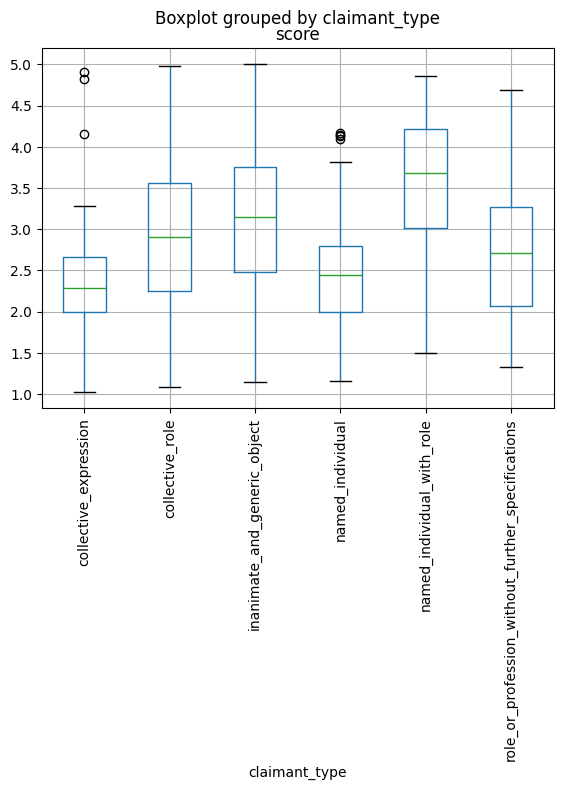

In [102]:
# create boxplot per category
grouped_df.boxplot(column=score_column, by='claimant_type', rot=90)

In [104]:
model = ols(f'{score_column} ~ C(claimant_type)', data=grouped_df).fit()

sm.stats.anova_lm(model, typ=2)

,sum_sq,df,F,PR(>F)
C(claimant_type),92.981366,5.0,26.945098,2.618027e-25
Residual,574.208316,832.0,NaN,NaN


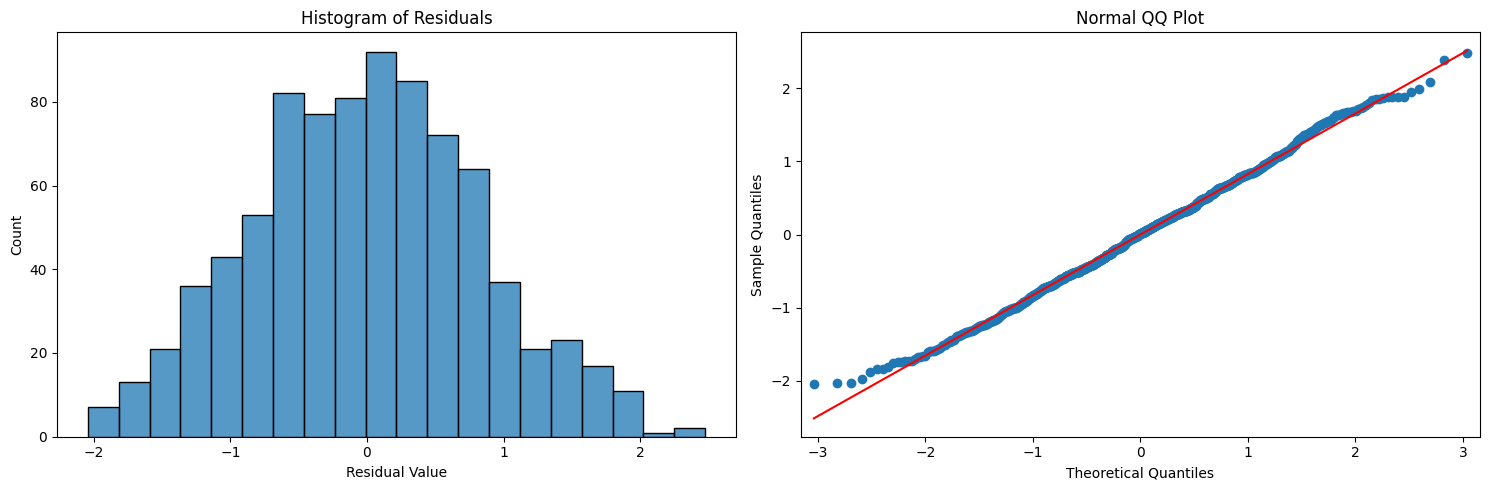

In [110]:
# check for normality assumption

residuals = model.resid

fig, ax = plt.subplots(1,2, figsize=(15,5))

sns.histplot(residuals, ax=ax[0])
ax[0].set_xlabel("Residual Value")
ax[0].set_title("Histogram of Residuals")

sm.qqplot(residuals, line='s',ax = ax[1])
ax[1].set_title("Normal QQ Plot")

plt.tight_layout()
plt.show()

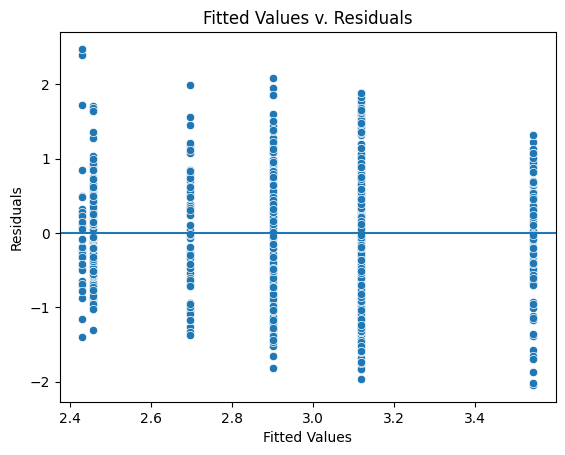

In [106]:
# check for homoscedacity (constant variance) assumption

fig = sns.scatterplot(x = model.fittedvalues, y = model.resid)

fig.set_xlabel("Fitted Values")
fig.set_ylabel("Residuals")

fig.set_title("Fitted Values v. Residuals")
fig.axhline(0)

plt.show()

In [107]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.139
Model:                            OLS   Adj. R-squared:                  0.134
Method:                 Least Squares   F-statistic:                     26.95
Date:                Fri, 28 Jun 2024   Prob (F-statistic):           2.62e-25
Time:                        13:35:58   Log-Likelihood:                -1030.7
No. Observations:                 838   AIC:                             2073.
Df Residuals:                     832   BIC:                             2102.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=========================================================================================================================================
                                                                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                 2.4304      0.138     17.553      0.000       2.159       2.702
C(claimant_type)[T.collective_role]                                       0.4720      0.154      3.058      0.002       0.169       0.775
C(claimant_type)[T.inanimate_and_generic_object]                          0.6875      0.145      4.728      0.000       0.402       0.973
C(claimant_type)[T.named_individual]                                      0.0256      0.154      0.166      0.868      -0.277       0.329
C(claimant_type)[T.named_individual_with_role]                            1.1137      0.163      6.829      0.000       0.794       1.434
C(claimant_type)[T.role_or_profession_without_further_specifications]     0.2652      0.173      1.532      0.126      -0.074       0.605
==============================================================================
Omnibus:                        4.640   Durbin-Watson:                   1.547
Prob(Omnibus):                  0.098   Jarque-Bera (JB):                3.967
Skew:                           0.088   Prob(JB):                        0.138
Kurtosis:                       2.713   Cond. No.                         13.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [109]:
# run more robust Kruskal-Wallis H test in case an anova assumption is not met
from scipy.stats import kruskal

result = kruskal(grouped_df[grouped_df['claimant_type'] == 'named_individual'][score_column], grouped_df[grouped_df['claimant_type'] == 'named_individual_with_role'][score_column],grouped_df[grouped_df['claimant_type'] == 'role_or_profession_without_further_specifications'][score_column],grouped_df[grouped_df['claimant_type'] == 'collective_expression'][score_column],grouped_df[grouped_df['claimant_type'] == 'collective_role'][score_column],grouped_df[grouped_df['claimant_type'] == 'inanimate_and_generic_object'][score_column])
print(result)

alpha = 0.05
if result.pvalue < alpha:
    print('Reject null hypothesis -> there is a significant difference between claimant types')
else:
    print('Fail to reject null hypothesis -> there is _no_ significant difference between claimant types')

KruskalResult(statistic=120.763313832371, pvalue=2.1629391383150696e-24)
Reject null hypothesis -> there is a significant difference between claimant types


### Claimant types X Publisher types Heatmaps

In [122]:
# merge with publisher annotations
df = gather_flattened_dataset('./data/claimant_data_processed/flattened/')

publisher_df = pd.read_csv('./annotations/publisher_annotations.csv')
df = pd.merge(df, publisher_df, on='publisher')

df = pd.merge(df, claimant_df[['task_id', 'claimant_type']], on='task_id')

annotation_df = df[['task_id', 'claimant_type', 'category']]
del df

annotation_df = annotation_df.rename(columns={'category': 'publisher_type'}) #type:ignore
annotation_df['claimant_type'] = annotation_df['claimant_type'].apply(lambda type_: type_.replace('_', ' '))

annotation_df.head()

,task_id,claimant_type,publisher_type
0,f79dff90-7723-4c33-9582-33e46ab6176c,named individual with role,not established
1,f040bde3-4c11-482c-b7e3-4bd080b1a7f7,inanimate and generic object,established
2,e3f62e34-fb40-4bda-a5b4-acd3d72c1160,named individual with role,governmental/institutional
3,edf664b7-4b4b-4eca-8bfb-dbb814528de7,role or profession without further specifications,not established
4,cca66bf3-17a3-4c5d-8a91-ce303c7bc5a0,collective expression,established


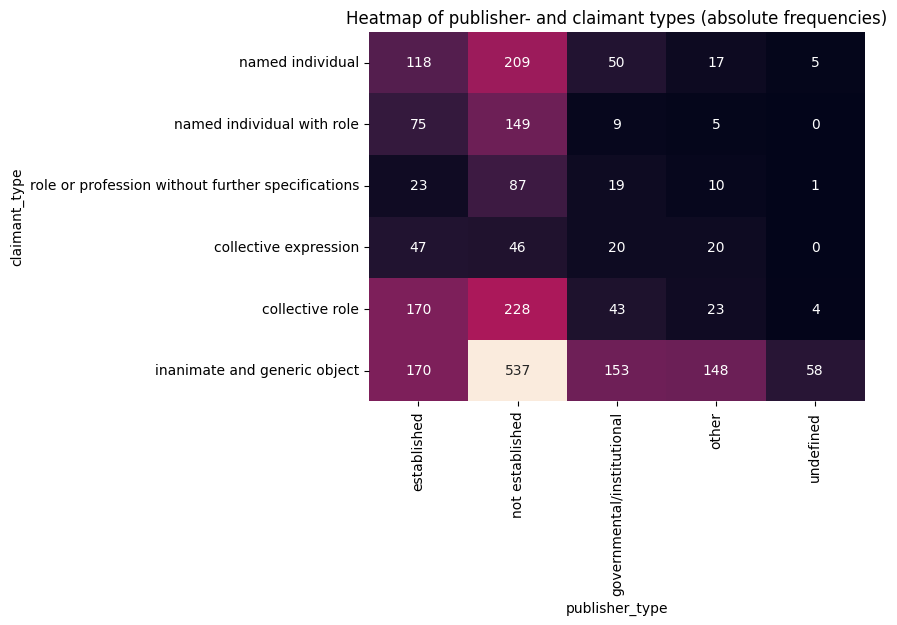

In [136]:
# heatmap with publisher and claimant categories and their absolute frequencies
crosstab = pd.crosstab(annotation_df['claimant_type'], annotation_df['publisher_type'])
crosstab = crosstab.reindex(['established' ,'not established', 'governmental/institutional', 'other', 'undefined'], axis='columns')
crosstab = crosstab.reindex(['named individual', 'named individual with role', 'role or profession without further specifications', 'collective expression', 'collective role', 'inanimate and generic object'], axis='index')

ax = sns.heatmap(crosstab, annot=True, fmt='.0f', cbar=False)

plt.title('Heatmap of publisher- and claimant types (absolute frequencies)')
plt.show()

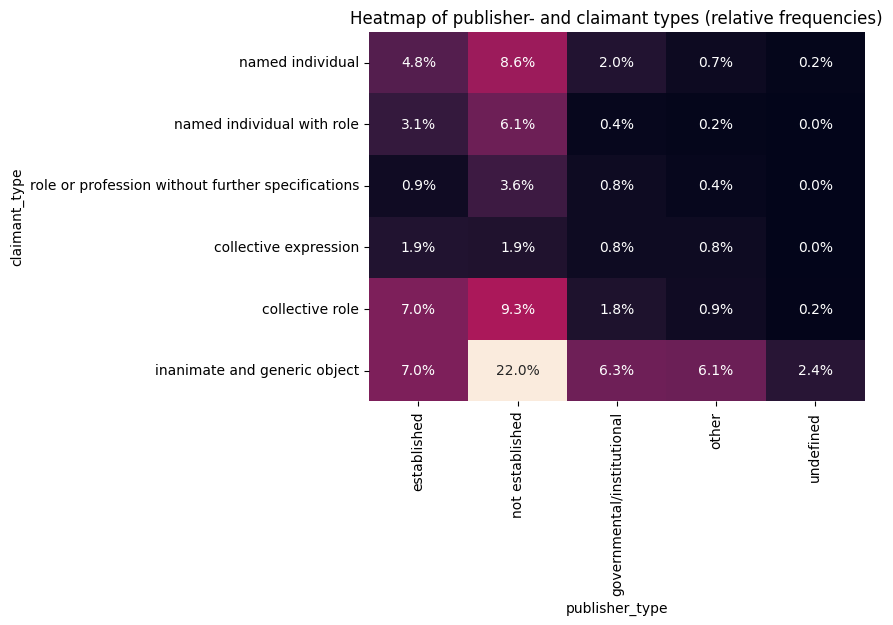

In [24]:
# heatmap with publisher and claimant categories and their relative frequencies
crosstab = pd.crosstab(annotation_df['claimant_type'], annotation_df['publisher_type'], normalize=True)
crosstab = crosstab.reindex(['established' ,'not established', 'governmental/institutional', 'other', 'undefined'], axis='columns')
crosstab = crosstab.reindex(['named individual', 'named individual with role', 'role or profession without further specifications', 'collective expression', 'collective role', 'inanimate and generic object'], axis='index')

ax = sns.heatmap(crosstab, annot=True, fmt='.1%', cbar=False)

plt.title('Heatmap of publisher- and claimant types (relative frequencies)')
plt.show()

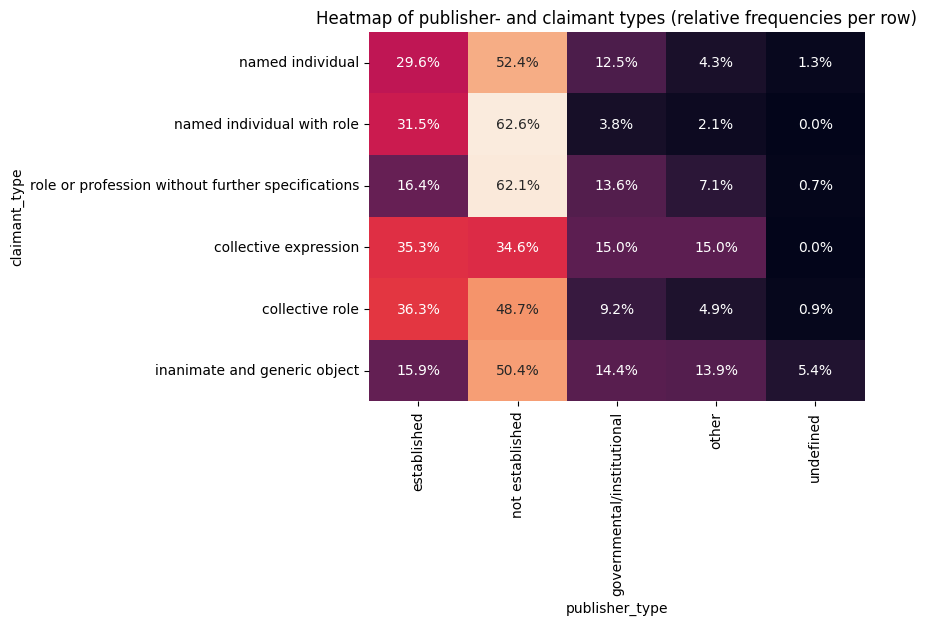

In [25]:
crosstab = pd.crosstab(annotation_df['claimant_type'], annotation_df['publisher_type'], normalize='index')
crosstab = crosstab.reindex(['established' ,'not established', 'governmental/institutional', 'other', 'undefined'], axis='columns')
crosstab = crosstab.reindex(['named individual', 'named individual with role', 'role or profession without further specifications', 'collective expression', 'collective role', 'inanimate and generic object'], axis='index')

ax = sns.heatmap(crosstab, annot=True, fmt='.1%', cbar=False)

plt.title('Heatmap of publisher- and claimant types (relative frequencies per row)')
plt.show()

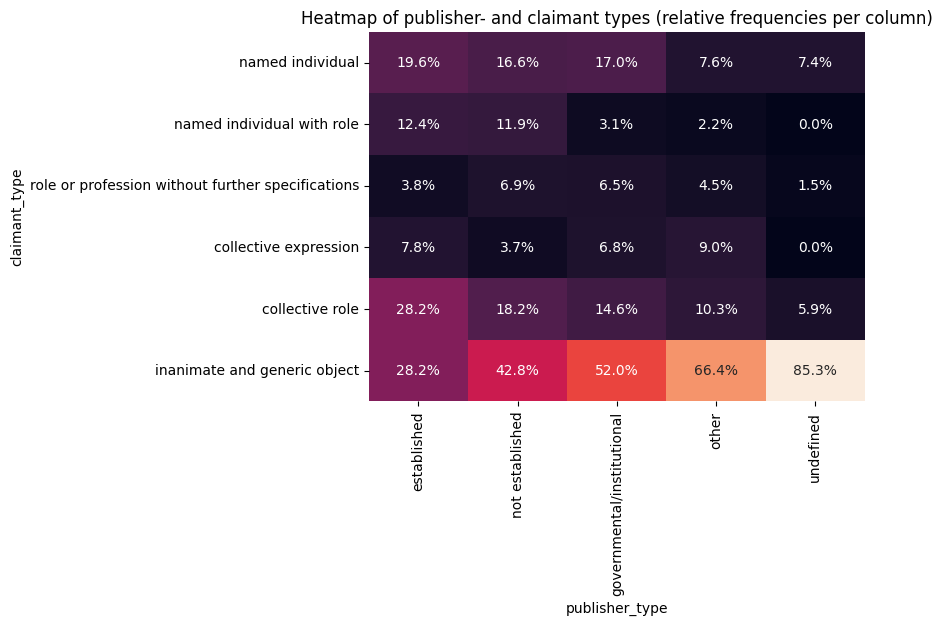

In [26]:
crosstab = pd.crosstab(annotation_df['claimant_type'], annotation_df['publisher_type'], normalize='columns')
crosstab = crosstab.reindex(['established' ,'not established', 'governmental/institutional', 'other', 'undefined'], axis='columns')
crosstab = crosstab.reindex(['named individual', 'named individual with role', 'role or profession without further specifications', 'collective expression', 'collective role', 'inanimate and generic object'], axis='index')

ax = sns.heatmap(crosstab, annot=True, fmt='.1%', cbar=False)

plt.title('Heatmap of publisher- and claimant types (relative frequencies per column)')
plt.show()

In [123]:
# add mean reliability score per task to the annotation_df
df = gather_dataset('./data/claimant_data_processed/')
df = df.groupby('task_id', as_index=False).agg({'score': 'mean'})
annotation_df = pd.merge(annotation_df, df[['task_id', 'score']], on='task_id')
del df
annotation_df.head()

,task_id,claimant_type,publisher_type,score
0,f79dff90-7723-4c33-9582-33e46ab6176c,named individual with role,not established,4.3
1,f040bde3-4c11-482c-b7e3-4bd080b1a7f7,inanimate and generic object,established,3.6
2,e3f62e34-fb40-4bda-a5b4-acd3d72c1160,named individual with role,governmental/institutional,4.2
3,edf664b7-4b4b-4eca-8bfb-dbb814528de7,role or profession without further specifications,not established,2.5
4,cca66bf3-17a3-4c5d-8a91-ce303c7bc5a0,collective expression,established,2.5


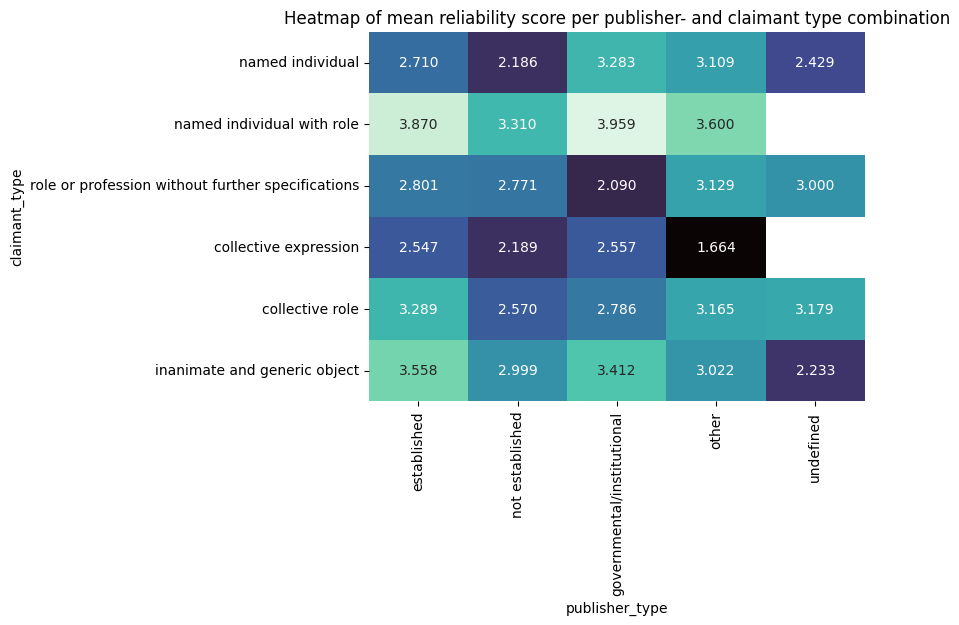

In [134]:
# heatmap of mean score per combination of claimant and publisher

crosstab = annotation_df.groupby(['claimant_type', 'publisher_type'])['score'].mean().unstack(fill_value=None)
crosstab = crosstab.reindex(['established' ,'not established', 'governmental/institutional', 'other', 'undefined'], axis='columns')
crosstab = crosstab.reindex(['named individual', 'named individual with role', 'role or profession without further specifications', 'collective expression', 'collective role', 'inanimate and generic object'], axis='index')

ax = sns.heatmap(crosstab, annot=True, fmt='.3f', cbar=False, cmap='mako')

plt.title('Heatmap of mean reliability score per publisher- and claimant type combination')
plt.show()

### Two-way ANOVA (Work in progress)
_This test is ran on a grouped df, while we should (probably?) run it on the df as a whole_

In [151]:
# run two-way anova on dataset without undefined publishers
model = ols(f'score ~ C(claimant_type) + C(publisher_type) + C(claimant_type):C(publisher_type)', data=annotation_df[annotation_df['publisher_type'] != 'undefined']).fit()

sm.stats.anova_lm(model, typ=2)

,sum_sq,df,F,PR(>F)
C(claimant_type),294.391246,5.0,95.148056,1.744647e-91
C(publisher_type),138.983509,3.0,74.866417,3.013393e-46
C(claimant_type):C(publisher_type),69.493412,15.0,7.486820,1.608638e-16
Residual,1455.433225,2352.0,NaN,NaN


In [147]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.244
Model:                            OLS   Adj. R-squared:                  0.236
Method:                 Least Squares   F-statistic:                     32.95
Date:                Tue, 02 Jul 2024   Prob (F-statistic):          1.33e-124
Time:                        11:44:57   Log-Likelihood:                -2789.1
No. Observations:                2376   AIC:                             5626.
Df Residuals:                    2352   BIC:                             5765.
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
=========================================================================================================================================================================================
                                                                                                                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                                                 2.5468      0.115     22.196      0.000       2.322       2.772
C(claimant_type)[T.collective role]                                                                                       0.7422      0.130      5.725      0.000       0.488       0.996
C(claimant_type)[T.inanimate and generic object]                                                                          1.0108      0.130      7.797      0.000       0.757       1.265
C(claimant_type)[T.named individual]                                                                                      0.1632      0.136      1.203      0.229      -0.103       0.429
C(claimant_type)[T.named individual with role]                                                                            1.3237      0.146      9.045      0.000       1.037       1.611
C(claimant_type)[T.role or profession without further specifications]                                                     0.2544      0.200      1.271      0.204      -0.138       0.647
C(publisher_type)[T.governmental/institutional]                                                                           0.0103      0.210      0.049      0.961      -0.402       0.422
C(publisher_type)[T.not established]                                                                                     -0.3574      0.163     -2.190      0.029      -0.677      -0.037
C(publisher_type)[T.other]                                                                                               -0.8825      0.210     -4.202      0.000      -1.294      -0.471
C(claimant_type)[T.collective role]:C(publisher_type)[T.governmental/institutional]                                      -0.5136      0.249     -2.060      0.039      -1.002      -0.025
C(claimant_type)[T.inanimate and generic object]:C(publisher_type)[T.governmental/institutional]                         -0.1557      0.228     -0.684      0.494      -0.602       0.291
C(claimant_type)[T.named individual]:C(publisher_type)[T.governmental/institutional]                                      0.5625      0.248      2.264      0.024       0.075       1.050
C(claimant_type)[T.named individual with role]:C(publisher_type)[T.governmental/institutional]                            0.0779      0.348      0.224      0.823      -0.605       0.760
C(claimant_type)[T.role or profession without further specifications]:C(publisher_type)[T.governmental/inst